# Filtering with non-increasing criterion - The shaping framework

This notebook implements an exemple of application of the framework proposed in 

> Yongchao Xu, Thierry Géraud, Laurent Najman. Connected Filtering on Tree-Based Shape-Spaces. IEEE Transactions on Pattern Analysis and Machine Intelligence, Institute of Electrical and Electronics Engineers, 2016, 38 (6), pp.1126 - 1140. [⟨10.1109/TPAMI.2015.2441070](https://dx.doi.org/10.1109/TPAMI.2015.2441070)⟩. [⟨hal-01162437⟩](https://hal.archives-ouvertes.fr/hal-01162437)

It is an extension of connected filters that allows to deal with non-increasing criterion.


In the following, we are going to keep the "most circular objects" in an image, and remove the rest.

The principle is the following: we first build a max-tree that contains all the connected components of the upper-levels of the image. Then we assess how circular those components are, using a circularity criterion. We then transform the max-tree into a graph, each node of the max-tree having as neighbors in the graph its parent and its children. We then weight the nodes on the graph with the circularity criterion. Finally, we compute a min-tree of the weighted graph, and filter the graph by removing the less cicular nodes. Reconstructing an image from the preserved nodes of the graph provides the result. This is illustrated in the following figure.

<img src="http://laurentnajman.org/uploads/images/new_shema.png" alt="Shaping explaination" width="400" margin="auto" />


In [0]:
%%capture
!pip install higra

In [0]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from skimage import data

import higra as hg

try:
    from utils import * # imshow, locate_resource
except: # we are probably running from the cloud, try to fetch utils functions from URL
    import urllib.request as request; exec(request.urlopen('https://github.com/higra/Higra-Notebooks/raw/master/utils.py').read(), globals())

Let us take a simple image, which contains coins.

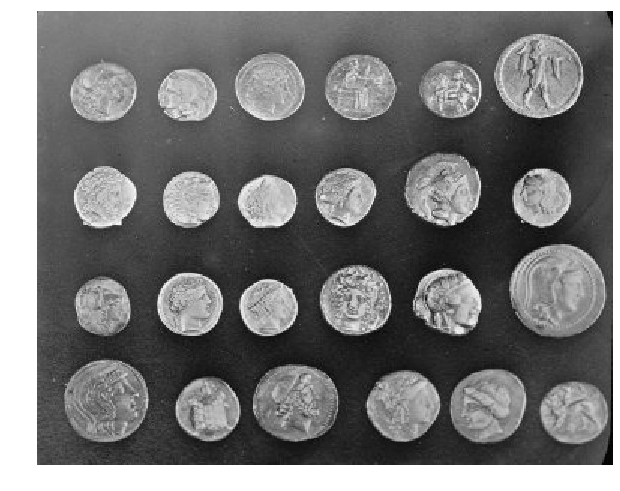

(<Figure size 576x454.5 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x7fe2ac354160>)

In [67]:
image = data.coins()

# discard the color channel (if any)
size = image.shape[:2]
imshow(image, cmap='gray')

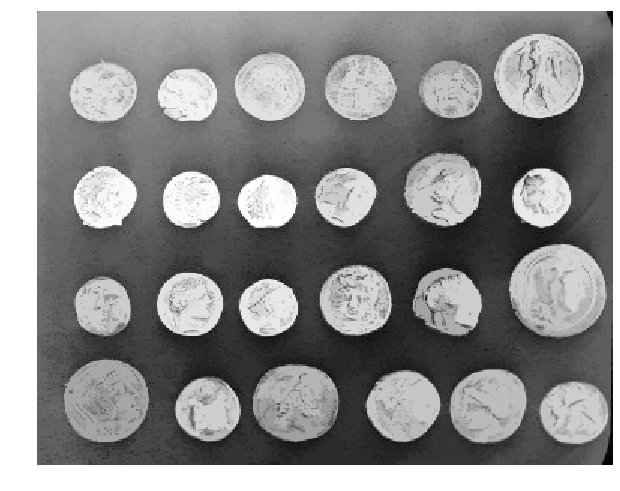

(<Figure size 576x454.5 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x7fe2ac1d01d0>)

In [68]:
#Build the max tree
graph = hg.get_4_adjacency_graph(size)
tt1 , aa1 = hg.component_tree_max_tree(graph, image)

#Remove small components
area = hg.attribute_area(tt1)
condRemoval = area < 500
t1 , n_map = hg.simplify_tree(tt1, condRemoval)
a1 = aa1[n_map]


# show equivalent filtered image
filtered_a1 = hg.reconstruct_leaf_data(t1,a1)
imshow(filtered_a1, cmap='gray')



The criterion we choose in this example is based on image moments, and is described in [Wikipedia](https://en.wikipedia.org/wiki/Image_moment). 

In [69]:
# Circularity is 1 for a disk, 0 if not
def circularity(tree, size):
  emb = hg.EmbeddingGrid2d(size)
  coord = emb.lin2grid(np.arange(tree.num_leaves()))
    
  m = np.zeros((tree.num_leaves(), 6), dtype=np.float64)
  m[:, 0] = 1
  m[:, 1] = coord[:, 0]
  m[:, 2] = coord[:, 1]
  m[:, 3] = coord[:, 0] * coord[:, 1]
  m[:, 4] = coord[:, 0] * coord[:, 0]
  m[:, 5] = coord[:, 1] * coord[:, 1]
  m = hg.accumulate_sequential(tree, m, hg.Accumulators.sum)
  m00 = m[:, 0]
  m10 = m[:, 1]
  m01 = m[:, 2]
  m11 = m[:, 3]
  m20 = m[:, 4]
  m02 = m[:, 5]
  xmean = m10 / m00
  ymean = m01 / m00
  xvar = m20 / m00 - xmean * xmean
  yvar = m02 / m00 - ymean * ymean
  xycovar = m11 / m00 - xmean*ymean
  lambda1 = np.maximum(0, 0.5 * (xvar + yvar + np.sqrt(4 * xycovar * xycovar + (xvar - yvar) * (xvar - yvar))))
  lambda2 = np.maximum(0, 0.5 * (xvar + yvar - np.sqrt(4 * xycovar * xycovar + (xvar - yvar) * (xvar - yvar))))
  return np.nan_to_num(lambda2[tree.num_leaves():] / lambda1[tree.num_leaves():])

circ = circularity(t1, size)
print(circ)

[0.70969449 0.719625   0.74395793 ... 0.62262379 0.62262427 0.62261707]


Now transfrom the max-tree into a graph.

In [0]:
sources, targets = t1.edge_list()
g2 = hg.UndirectedGraph(t1.num_vertices() - t1.num_leaves())
g2.add_edges(sources[t1.num_leaves():] - t1.num_leaves(), targets[t1.num_leaves():] - t1.num_leaves())

We assess how circular a component (node of the graph) is by its depth in the min-tree.

In [71]:
# Compute the min tree
t2 , a2 = hg.component_tree_min_tree(g2, circ)
# Compute the depth of the basin of g2
depth = hg.attribute_height(t2, a2)
# Some stats (just for fun)
print("depth max = ", depth.max(), "min=", depth.min(), "mean =", depth.mean())

depth max =  0.9872828860228604 min= 0.0 mean = 0.10949005865754155


Now we are going to remove the nodes of t2 which are not relevant (depth is too low), and reconstruct an image from the filtered t1.

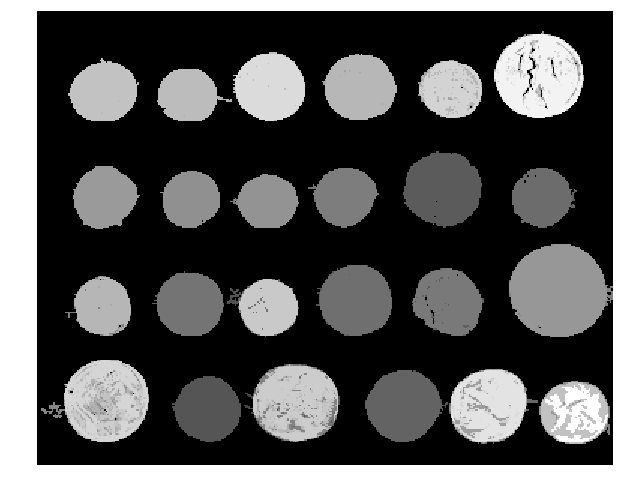

(<Figure size 576x454.5 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x7fe2abe4b390>)

In [72]:
# Leaves of t2 which belongs to a node with unsuficient depth
cond_removal = depth[t2.parents()[np.arange(t2.num_leaves())]] < 0.75
# transfer those t2-leaves to t1 (leaves of t2 are nodes of t1)
cond_removal = np.concatenate((np.zeros(t1.num_leaves(), dtype=np.bool), cond_removal))

# Reconstruct t1 
filtered_a1 = hg.reconstruct_leaf_data(t1, a1, cond_removal)

imshow(filtered_a1, cmap='gray')